In [1]:
import cv2
import numpy as np
import mediapipe as mp
import logging
from math import sqrt
import time  # Import time module to manage timing

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose


Matplotlib is building the font cache; this may take a moment.


In [2]:
from datetime import datetime


def calculate_angle(a, b, c):
    """
    b is the midpoint of a and c (e.g. left hip, left elbow and left shoulder)
    our case will be left-hip, left-knee and left-ankle
    """

    a = np.array(a)  # First
    b = np.array(b)  # Mid
    c = np.array(c)  # End

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(
        a[1] - b[1], a[0] - b[0]
    )
    angle = np.abs(radians * 180.0 / np.pi)
    
    if angle > 180.0:
        angle = 360 - angle

    return angle


import datetime


def to_timestamp(time_float):
    return datetime.datetime.fromtimestamp(time_float).strftime("%Y-%m-%d %H:%M:%S,%f")


def calculate_distance(p1, p2):
    return sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)


def should_start_timer(
    keypoints,
    hip_displacement,
    knee_displacement,
    ankle_displacement,
    threshold_angle=80.0,
    hip_thresh=3.0,
    knee_thresh=3.0,
    ankle_thresh=1.5,
):
    """
    Determine if the timer should start based on displacement conditions.
    """
    # calculate angle between hip and shoulder and knee
    knee, hip, shoulder = keypoints
    angle = calculate_angle(knee, hip, shoulder)
    print(f"knee hip shoulder angle: {angle:.2f} degrees")
    return angle < threshold_angle and (
        hip_displacement > hip_thresh
        or knee_displacement > knee_thresh
        or ankle_displacement > ankle_thresh
    )


def get_landmark_coordinates(landmarks, frame_width, frame_height):
    hip = [
        landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x * frame_width,
        landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y * frame_height,
    ]
    knee = [
        landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x * frame_width,
        landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y * frame_height,
    ]
    ankle = [
        landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x * frame_width,
        landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y * frame_height,
    ]
    shoulder = [
        landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x * frame_width,
        landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y * frame_height,
    ]
    return hip, knee, ankle, shoulder


def determine_failure(elapsed_time, threshold_time=12):
    """
    Determine if the user has failed based on the elapsed time.
    """
    # convert elapsed time to seconds
    logging.info(f"Elapsed time: {elapsed_time}")
    return "FAILED" if elapsed_time > threshold_time else "PASSED"


def summarise_results(
    counter,
    elapsed_time,
    rep_durations,
    joint_displacement_map=None,
    joint_velocity_map=None,
):

    logging.info(
        "========================= Video processing summary ========================="
    )
    logging.info(f"Pass status: {determine_failure(elapsed_time)}")
    logging.info(
        f"Total repetitions: {counter} completed in {elapsed_time:.2f} seconds"
    )
    if rep_durations:
        for reps in rep_durations:
            logging.info(f"Duration: {reps:.2f} seconds")
        logging.info(
            f"Maximum duration per repetition: {max(rep_durations):.2f} seconds"
        )
        logging.info(
            f"Average duration per repetition: {sum(rep_durations) / len(rep_durations):.2f} seconds"
        )


def display_knee_and_hip_angle(image, knee_angle, knee, hip_angle, hip, x_displacement=60):
    """
    Display the knee angle on the screen. 60px to the right of the knee
    """
    cv2.putText(
        image,
        f"{knee_angle} deg",
        (int(knee[0] + x_displacement), int(knee[1])),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )
    cv2.putText(
        image,
        f"{hip_angle} deg",
        (int(hip[0] + x_displacement), int(hip[1])),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )


def draw_joint_displacement(prev_point, curr_point, image):
    prev_x, prev_y = map(int, prev_point)
    curr_x, curr_y = map(int, curr_point)
    cv2.circle(image, (curr_x, curr_y), 10, (0, 0, 255), -1)
    cv2.line(image, (prev_x, prev_y), (curr_x, curr_y), (0, 255, 0), 2)


def display_x_and_y_from_point(point):
    return f"[x: {point[0]}, y: {point[1]}]"


def calculate_and_draw_joint_displacement(
    prev_frame, prev_points, curr_points, image, joint_displacement_history, real_time
):
    logging.info(
        "========================= Optical flow results ========================="
    )
    joint_names = ("HIP", "KNEE", "ANKLE")  # Names of the joints
    prev_hip, prev_knee, prev_ankle = prev_points
    hip, knee, ankle = curr_points
    if prev_frame is not None:
        for prev_point, curr_point, _, joint_name in zip(
            [prev_hip, prev_knee, prev_ankle],
            [hip, knee, ankle],
            [(0, 0, 255)] * 3,
            joint_names,
        ):
            draw_joint_displacement((prev_point), curr_point, image)
            displacement = calculate_distance(prev_point, curr_point)
            logging.info(
                f"{joint_name} Displacement: {displacement:.2f} px (from {display_x_and_y_from_point(prev_point)} to {display_x_and_y_from_point(curr_point)})"
            )
            joint_displacement_history[joint_name].append((real_time, displacement))
    return joint_displacement_history


def calculate_and_store_velocities(
    hip_displacement,
    knee_displacement,
    ankle_displacement,
    frame_time,
    joint_displacement,
    joint_velocity_history,
):
    hip_velocity = hip_displacement / frame_time
    knee_velocity = knee_displacement / frame_time
    ankle_velocity = ankle_displacement / frame_time
    logging.info(
        f"Hip Velocity: {hip_velocity:.2f} px/s, Knee Velocity: {knee_velocity:.2f} px/s, Ankle Velocity: {ankle_velocity:.2f} px/s"
    )
    joint_velocity_history["HIP"].append((to_timestamp(time.time()), hip_velocity))
    joint_velocity_history["KNEE"].append((to_timestamp(time.time()), knee_velocity))
    joint_velocity_history["ANKLE"].append((to_timestamp(time.time()), ankle_velocity))

    return joint_velocity_history


def display_information(image, counter, stage, max_angle):
    """
    Display the number of repetitions on the screen.
    """
    # Setup status box
    cv2.rectangle(image, (0, 0), (550, 100), (245, 117, 16), -1)

    # Rep data
    cv2.putText(
        image,
        "REPS",
        (15, 12),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 0),
        1,
        cv2.LINE_AA,
    )
    cv2.putText(
        image,
        str(counter),
        (10, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )

    # Stage data
    cv2.putText(
        image,
        "STAGE",
        (65, 12),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 0),
        1,
        cv2.LINE_AA,
    )
    cv2.putText(
        image,
        stage,
        (60, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )
    # display max_angle per rep
    # display_max_angle(image, max_angle)

    cv2.putText(
        image,
        "MAX ANGLE",
        (300, 12),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 0),
        1,
        cv2.LINE_AA,
    )
    cv2.putText(
        image,
        f"{max_angle:.2f}",
        (250, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 255, 255),
        2,
    )


def display_timer(image, elapsed_time):
    """
    Display the elapsed time on the screen.
    """
    cv2.putText(
        image,
        f"Time: {elapsed_time:.2f} s",
        (800, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )


def draw_landmarks_and_connections(image, results):
    """
    Draw the landmarks and connections on the image.
    """
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
    )


def get_real_time_from_frames(frame_counter, fps):
    return frame_counter / fps

In [4]:
# Initialize variables for counter logic
counter = 0
stage = None
confirm_frames = 5
stage_counter = 0
max_angle_per_rep = 0
last_angle = 0
up_stage_threshold_angle = 135
down_stage_threshold_angle = 105

# Initialize variables for optical flow
prev_frame = None
prev_hip = None
prev_knee = None
prev_ankle = None

# for optical flow postprocessing
joint_history = {
    "HIP": [],
    "KNEE": [],
    "ANKLE": [],
}

joint_displacement_history = {
    "HIP": [],
    "KNEE": [],
    "ANKLE": [],
}
joint_velocity_history = {
    "HIP": [],
    "KNEE": [],
    "ANKLE": [],
}

max_angles = []
frames_after_start = 0
frame_rate = None
frame_time = None
timer_started = False
start_time = None
elapsed_time = 0
finished = False
rep_durations = []  # List to store the duration of each repetition


with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    cap = cv2.VideoCapture("../test/CST_self1.mp4")
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1 / frame_rate
    
    while cap.isOpened() and not finished:
        ret, frame = cap.read()
        if not ret:
            logging.warning("No frame captured from the video source.")
            break
        
        frame_height, frame_width, _ = frame.shape
        # image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # image.flags.writeable = False
        image = frame
        results = pose.process(image)
        # image.flags.writeable = True
        # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        display_timer(image, elapsed_time)

        if timer_started:
            elapsed_time = get_real_time_from_frames(frames_after_start, frame_rate)
            frames_after_start += 1
            
        # Process the frame
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # Extract coordinates multiplied by frame dimensions for optical flow and angle calculation
            hip, knee, ankle, shoulder = get_landmark_coordinates(
                landmarks, frame_width, frame_height
            )
            
            joint_history["HIP"].append((get_real_time_from_frames(elapsed_time, frame_rate), hip))
            joint_history["KNEE"].append((get_real_time_from_frames(elapsed_time, frame_rate), knee))
            joint_history["ANKLE"].append((get_real_time_from_frames(elapsed_time, frame_rate), ankle))

            # Calculate angle for sit-stand logic
            angle = calculate_angle(hip, knee, ankle)
            hip_angle = calculate_angle(shoulder, hip, knee)
            display_knee_and_hip_angle(image, angle, knee, hip_angle, hip)
            
            if prev_hip and prev_knee and prev_ankle:
                 # Calculate displacements
                 # Optical flow visualization
                joint_displacement_history = calculate_and_draw_joint_displacement(
                    prev_frame,
                    [prev_hip, prev_knee, prev_ankle],
                    [hip, knee, ankle],
                    image,
                    joint_displacement_history,
                    get_real_time_from_frames(frames_after_start, frame_rate),
                )
                
                # =============== Runs only once ========================
                # Get most recent displacement from history
                hip_displacement = joint_displacement_history["HIP"][-1][1]
                knee_displacement = joint_displacement_history["KNEE"][-1][1]
                ankle_displacement = joint_displacement_history["ANKLE"][-1][1]
                
                # Determine if the action timer should start
                if not timer_started and should_start_timer(
                    # angle
                    (shoulder,knee,hip)
                    , hip_displacement, knee_displacement, ankle_displacement
                ):
                    # elapsed_time = get_real_time_from_frames(frames_after_start, frame_rate)
                    timer_started = True
                    logging.info(f"Timer started at {elapsed_time:.2f} seconds.")
           
            prev_frame = frame.copy()
            prev_hip, prev_knee, prev_ankle = hip, knee, ankle

            # Counting logic
            if stage is None:
                stage = "up" if angle > up_stage_threshold_angle else "down"

            if stage == "down" and angle > up_stage_threshold_angle:
                if stage_counter == 0:
                    rep_start_time = (
                        get_real_time_from_frames(frames_after_start, frame_rate)
                    )  # Reset start time at the beginning of a new rep
                stage_counter += 1
                if stage_counter >= confirm_frames:
                    stage = "up"
                    stage_counter = 0
                    counter += 1
                    logging.info(f"Transitioned to up. Total reps: {counter}")
                    max_angle_per_rep = 0  # Reset max angle for the new repetition
                    rep_duration = get_real_time_from_frames(frames_after_start, frame_rate) - rep_start_time
                    rep_durations.append(rep_duration)  # Store the duration of the rep
                    logging.info(
                        f"Repetition {counter} completed in {rep_duration:.2f} seconds."
                    )

            elif stage == "up" and angle < down_stage_threshold_angle:
                stage_counter += 1
                if stage_counter >= confirm_frames:
                    stage = "down"
                    stage_counter = 0
                    logging.info("Transitioned to down.")
            if counter >= 5:  # Check if 5 reps are completed
                if stage == "down":
                    finished = True
                    logging.info(
                        f"5 repetitions completed in {elapsed_time:.2f} seconds."
                    )
                    break
            # Update max angle
            if angle > max_angle_per_rep:
                max_angle_per_rep = angle
            last_angle = angle
            max_angles.append(max_angle_per_rep)

            display_information(image, counter, stage, max_angle_per_rep)
            draw_landmarks_and_connections(image, results)
        cv2.imshow("5 Rep Sit Stand Test", image)
        if cv2.waitKey(10) & 0xFF == ord("q"):
            break
    cap.release()
    cv2.destroyAllWindows()
    summarise_results(counter, elapsed_time, rep_durations)

2024-06-18 00:23:46,733 - INFO - ========================= Optical flow results =========================
2024-06-18 00:23:46,734 - INFO - HIP Displacement: 43.99 px (from [x: 726.7201137542725, y: 987.264404296875] to [x: 727.0358633995056, y: 943.2753753662109])
2024-06-18 00:23:46,736 - INFO - KNEE Displacement: 18.26 px (from [x: 643.5509490966797, y: 834.6297454833984] to [x: 647.5728464126587, y: 852.4423027038574])
2024-06-18 00:23:46,737 - INFO - ANKLE Displacement: 57.17 px (from [x: 696.3411998748779, y: 865.4616165161133] to [x: 643.3764338493347, y: 886.9866371154785])
2024-06-18 00:23:46,738 - INFO - Timer started at 0.00 seconds.
2024-06-18 00:23:46,835 - INFO - ========================= Optical flow results =========================
2024-06-18 00:23:46,836 - INFO - HIP Displacement: 16.01 px (from [x: 727.0358633995056, y: 943.2753753662109] to [x: 728.4592795372009, y: 927.3244857788086])
2024-06-18 00:23:46,837 - INFO - KNEE Displacement: 119.63 px (from [x: 647.572846

knee hip shoulder angle: 35.99 degrees


2024-06-18 00:23:47,032 - INFO - ========================= Optical flow results =========================
2024-06-18 00:23:47,033 - INFO - HIP Displacement: 21.43 px (from [x: 730.7138800621033, y: 908.6144256591797] to [x: 735.0694870948792, y: 929.5944786071777])
2024-06-18 00:23:47,035 - INFO - KNEE Displacement: 179.98 px (from [x: 643.4673285484314, y: 914.2729568481445] to [x: 641.3656783103943, y: 1094.2389678955078])
2024-06-18 00:23:47,036 - INFO - ANKLE Displacement: 184.67 px (from [x: 572.0295667648315, y: 1042.386360168457] to [x: 485.39475202560425, y: 1205.4758834838867])
2024-06-18 00:23:47,139 - INFO - ========================= Optical flow results =========================
2024-06-18 00:23:47,140 - INFO - HIP Displacement: 0.73 px (from [x: 735.0694870948792, y: 929.5944786071777] to [x: 734.9444103240967, y: 930.3182601928711])
2024-06-18 00:23:47,142 - INFO - KNEE Displacement: 110.69 px (from [x: 641.3656783103943, y: 1094.2389678955078] to [x: 650.5367732048035, y

In [ ]:
counter, elapsed_time, joint_history, joint_displacement_history

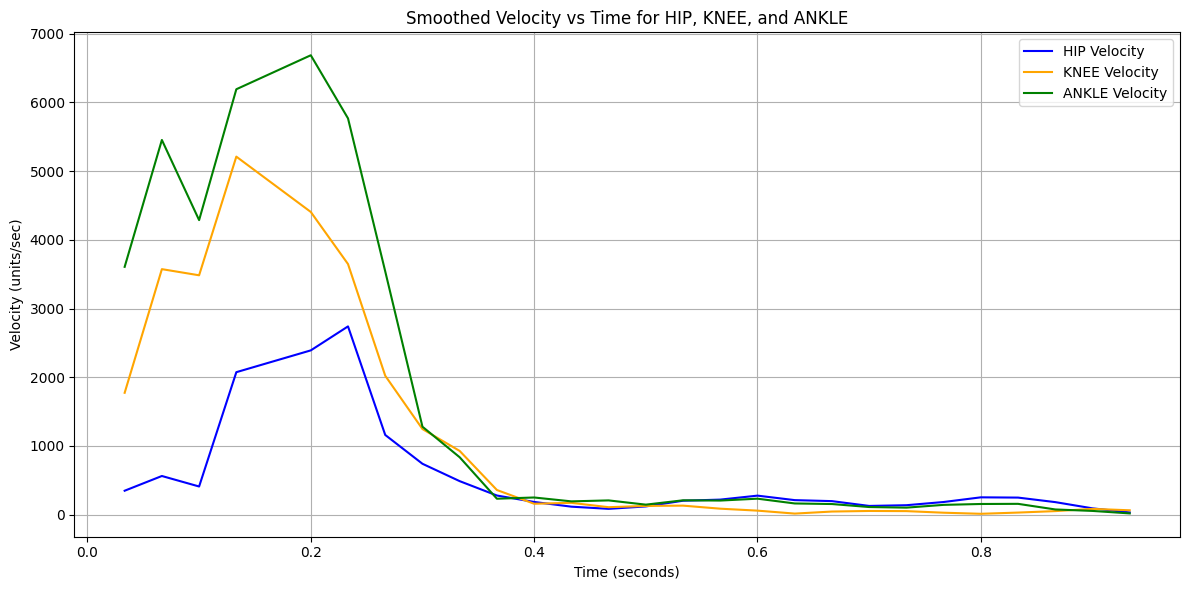

In [5]:
from datetime import datetime
import matplotlib.pyplot as plt

# VELOCITY TIME GRAPH
def parse_timestamp(ts):
    return datetime.strptime(ts, '%Y-%m-%d %H:%M:%S,%f')

# Function to calculate velocities
def calculate_velocities(data):
    velocities = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }
    times = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }
    # Loop over each keypoint type
    for key in data:
        for i in range(1, len(data[key])):
            t1 = data[key][i-1][0]
            t2 = data[key][i][0]
            delta_t = (t2 - t1)
            displacement = data[key][i][1]
            if delta_t > 0:  # To prevent division by zero
                velocity = displacement / delta_t
                velocities[key].append(velocity)
                times[key].append(t2) # The ending time that is associated with the velocity
    return times, velocities

times, velocities = calculate_velocities(joint_displacement_history)


def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_vt_graph(times, velocities, smoothed=False, box_pts=3, ):
    plt.figure(figsize=(12, 6))
    if smoothed:
        hip_velocities = smooth(velocities['HIP'], box_pts)
        knee_velocities = smooth(velocities['KNEE'], box_pts)
        ankle_velocities = smooth(velocities['ANKLE'], box_pts)
    else:
        hip_velocities = velocities['HIP']
        knee_velocities = velocities['KNEE']
        ankle_velocities = velocities['ANKLE']
    plt.plot(times['HIP'], hip_velocities, label='HIP Velocity', color='blue')
    plt.plot(times['KNEE'], knee_velocities, label='KNEE Velocity', color='orange')
    plt.plot(times['ANKLE'], ankle_velocities, label='ANKLE Velocity', color='green')
    smoothed = "Smoothed" if smoothed else ""
    plt.title(f"{smoothed} Velocity vs Time for HIP, KNEE, and ANKLE")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity (units/sec)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_vt_graph(times, velocities, smoothed=True)


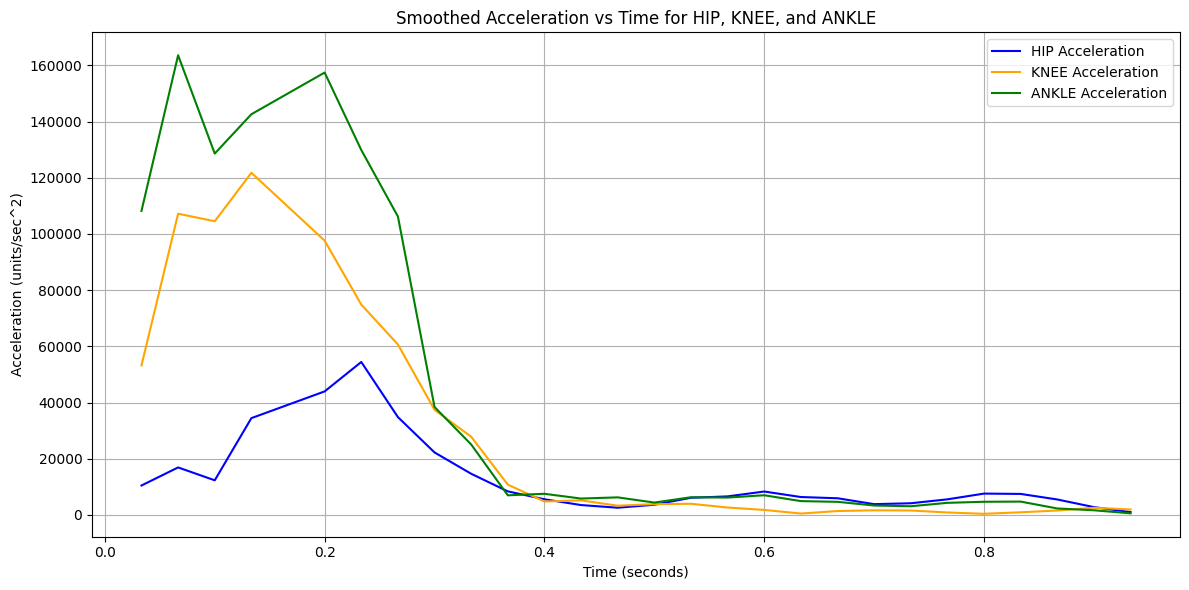

In [6]:
# Acceleration - time graph
def calculate_acceleration(data):
    accelerations = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }
    times = {
        "HIP": [],
        "KNEE": [],
        "ANKLE": [],
    }
    # Loop over each keypoint type
    for key in data:
        for i in range(1, len(data[key])):
            t1 = data[key][i-1][0]
            t2 = data[key][i][0]
            delta_t = (t2 - t1)
            displacement = data[key][i][1]
            if delta_t > 0:  # To prevent division by zero
                velocity = displacement / delta_t
                accelerations[key].append(velocity / delta_t)
                times[key].append(t2) # The ending time that is associated with the acceleration
    return times, accelerations

times, accelerations = calculate_acceleration(joint_displacement_history)

def plot_at_graph(times, accelerations, smoothed=False, box_pts=3):
    plt.figure(figsize=(12, 6))
    if smoothed:
        hip_accelerations = smooth(accelerations['HIP'], box_pts)
        knee_accelerations = smooth(accelerations['KNEE'], box_pts)
        ankle_accelerations = smooth(accelerations['ANKLE'], box_pts)
    else:
        hip_accelerations = accelerations['HIP']
        knee_accelerations = accelerations['KNEE']
        ankle_accelerations = accelerations['ANKLE']
    plt.plot(times['HIP'], hip_accelerations, label='HIP Acceleration', color='blue')
    plt.plot(times['KNEE'], knee_accelerations, label='KNEE Acceleration', color='orange')
    plt.plot(times['ANKLE'], ankle_accelerations, label='ANKLE Acceleration', color='green')
    smoothed = "Smoothed" if smoothed else ""
    plt.title(f"{smoothed} Acceleration vs Time for HIP, KNEE, and ANKLE")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Acceleration (units/sec^2)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_at_graph(times, accelerations, smoothed=True)

In [7]:
# 4. Frequency Analysis
# Performing a Fourier Transform to analyze the frequency components of the motion can also help in identifying the smoothness. Smooth motions typically have fewer high-frequency components.

# Example of Frequency Analysis Plot:
from scipy.fft import fft, fftfreq

# Calculate FFT
hip_fft = fft(hip_velocity_history)
frequencies = fftfreq(len(hip_velocity_history), d=frame_time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(hip_fft), label='Hip Velocity Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Analysis of Hip Motion')
plt.xlim([0, 5])  # Limiting to relevant frequencies
plt.legend()
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'scipy'